# 实验一：从零开始实现基于Transformer的语言模型

## 实验目标

在本次试验中，你将实现一个Decoder-only的Transformer模型：GPT。你将使用实验提供的中文语料训练这个GPT模型。

我们在此notebook中提供了训练一个Transformer模型的基础代码框架。请你将未实现的功能补充完整。

参考资料：
- 课件
- Transformer原文：[Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)
- GPT-1原文：[Improving Language Understanding by Generative Pre-Training](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf)

## 环境准备

In [ ]:
!pip install -r /content/drive/MyDrive/TransformerLab/requirements.txt
from google.colab import drive
drive.mount('/content/drive')
base_dir = "/content/drive/MyDrive/TransformerLab"
data_dir = os.path.join(base_dir, "data")

%cd $base_dir

!ls data

请使用实验提供的`requirements.txt`配置环境，推荐使用python 3.10。

In [ ]:
import os
import tiktoken
import numpy as np
import random
import time
import math
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

from tensorboardX import SummaryWriter
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

device = "cuda"

seed = 1228
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
np.random.seed(seed)
random.seed(seed)

In [ ]:
!nvidia-smi

Thu Oct 16 16:06:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   32C    P4             12W /   80W |    1295MiB /   6141MiB |     39%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 模型输入

模型无法直接理解文本，因此需要先将文本进行子词切分（tokenize），即根据词表把各个文本token转换为对应的整数id。请你运行下面的单元格，初步尝试使用cl100k-base版本的tokenizer进行子词切分。

In [ ]:
enc = tiktoken.get_encoding("cl100k_base")

text = "你好，我在学习NLP"
enc.encode_ordinary(text)

[57668, 53901, 3922, 37046, 19000, 48864, 18259, 254, 45, 12852]

本次试验的数据集为天工发布的SkyPile数据集的子集，位于`./data`中。为了提高训练效率，我们需要先对原始数据集进行tokenize，请你在下方的单元格中运行`./data/prepare.py`，将字符串格式的数据集转为numpy整数格式，并切分训练集和验证集：

In [ ]:
%run data/prepare.py

=============================== example ===============================
其实不难看出，在上述关系中，只有夫妻关系是最基本的。婆婆、儿媳、祖父母之间的关系不应该一直绑在一起。许多家庭仍无法“打破”这些亲密关系的实际压力或家庭感情:一方面老人承受生理和心理压力帮助孩子照顾家庭但另一方面他们不能没有他们的子孙。感受:一方面，孩子们对下一代的养育方式有很多抱怨，另一方面，他们无法承受没有老人帮助的压力。因此，矛盾会一次又一次地出现。
在亲密关系中适度的“分手”并不意味着放弃亲情。不管亲情有多好，它也需要呼吸的空间。传统的三代同堂的家庭模式显然不能适应现在的社会。如何尽快完成传统家庭向现代家庭的过渡，是家庭和社会都必须面对的问题。
中国人民大学人口与发展研究中心副主任宋健认为，生活在同一屋檐下，不同的一代人有着不同的生活习惯和生活方式，这不可避免地会产生摩擦和相互适应的问题。房价居高不下，居住空间相对狭小。城市家庭尤其如此。
这种家庭冲突的背后其实是合理分担育儿责任的问题。无论祖父母是愿意照顾孙辈，还是选择享受轻松自由的晚年，都应该得到认可和尊重。目前，有必要尽快完善社会化包容性托儿服务，以缓解家庭育儿困难。


黄龙国际中心位于杭州市西湖区学院路77号，地处杭州黄龙商务区核心位置。项目以“新经济、新生态、新黄龙”的理念和“知识城市创新区”的项目定位，引领着杭州城市的产业升级和创新。
黄龙国际中心主打“知识盒子”建筑设计，拥有时尚、新潮的建筑立面，聚集不同功能的独立建筑物，打造出包容开放又具有链接性的空间。项目在2018年4月一举斩获开发项目行业最高奖——广厦奖。
项目整体分四期开发。一期G、H、I三幢楼宇由坤和自主开发建成，于2015年4月投入使用，于2015年5月获得了美国绿色建筑委员会颁发的LEED金级认证，并成功吸引蚂蚁金服、美图、有赞等国内互联网创新巨头率先入驻。
2016年初，坤和引进万科作为该项目股权合作方通过双方优质资源共享，在产品品质、创新等方面得到全方位提升。
二期A、B幢由美国KPF设计，并于2018年4月一举获得房地产开发项目行业最高奖——广厦奖。A、B幢写字楼于2018年10月投入使用，B幢与全球领先的创造者社区及空间和服务提供商——WeWork正式签约。商业K-lab于2018

## Transformer (Decoder-only) 的实现 (17分)

回忆Transformer模型的结构（如下图）：

![](./img/transformer.png)

Decoder部分位于图中的右半侧，包括：Embedding、Positional Encoding、Masked Multi-Head Attention、Layernorm、Feed Forward Network，下面将分步实现各个部分。

### 模型配置

我们将配置模型的参数放入`GPTConfig`中，便于后续调用。

In [ ]:
@dataclass
class GPTConfig:
    block_size: int = 256  # 模型最大序列长度
    vocab_size: int = enc.n_vocab  # 词表大小
    n_layer: int = 6  # 模型层数
    n_head: int = 6  # 多头注意力的头数
    n_embd: int = 384  # 模型隐层维度
    dropout: float = 0.2  # 模型 dropout 比率

### Token Embedding (0.5分)

当输入id进入模型后，模型需要使用Embedding将离散的id转换为向量。

请你尝试使用`nn.Embedding`将下方的id转换为向量，并通过assert测试：

tensor([[ 0.6064,  1.3881,  0.3481,  0.3460,  1.8320],
        [ 0.9141,  0.6303,  0.4697, -0.3778, -1.5385]],
       grad_fn=<EmbeddingBackward0>)


Text(0, 0.5, 'seq len')

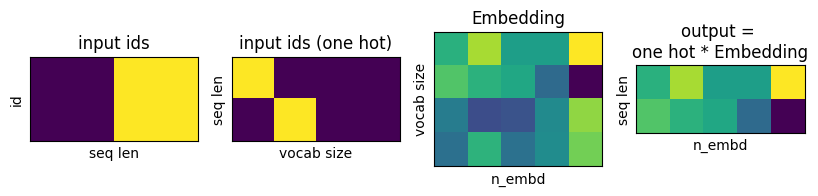

In [ ]:
seq_len = 2
vocab_size = 4
n_embd = 5

input_ids = torch.arange(seq_len, dtype=torch.long)  # shape = [T]

# ==============================================================================
# ===== 实现以下部分 (0.5分)
# =====     - 将 shape = [T] 的输入转为 shape = [T, n_embd] 的向量 (0.5分)
# ==============================================================================
wte = nn.Embedding(vocab_size, n_embd)
# ==============================================================================
# ===== 实现以上部分
# ==============================================================================

output = wte(input_ids)  # shape = [T, n_embd]
print(output)

assert output.shape == (input_ids.shape[0], n_embd), "Wrong implementation"

plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(input_ids.view(1, seq_len).numpy())
plt.title("input ids")
plt.xticks([])
plt.yticks([])
plt.xlabel("seq len")
plt.ylabel("id")
plt.subplot(1, 4, 2)
plt.imshow(torch.nn.functional.one_hot(input_ids, num_classes=vocab_size).numpy())
plt.title("input ids (one hot)")
plt.xticks([])
plt.yticks([])
plt.xlabel("vocab size")
plt.ylabel("seq len")
plt.subplot(1, 4, 3)
plt.imshow(wte.weight.detach().numpy())
plt.title("Embedding")
plt.xticks([])
plt.yticks([])
plt.xlabel("n_embd")
plt.ylabel("vocab size")
plt.subplot(1, 4, 4)
plt.imshow(output.detach().numpy())
plt.title("output = \none hot * Embedding")
plt.xticks([])
plt.yticks([])
plt.xlabel("n_embd")
plt.ylabel("seq len")

Embedding可以将token id转为向量。由于模型内部在进行多次运算后的结果还是一组向量，为了能正常生成文字，模型还需要一种能将向量转为token id的组件。这就是lm head，只需要将onehot和Embedding的功能倒转即可。

### Positional Encoding (0.5分)

GPT的位置编码与Embedding类似，是可学习的，这一点与Transformer原文中的`sin/cos`位置编码不同。

请你实现GPT的位置编码：

tensor([[ 2.1448,  0.6406, -0.3718,  1.1550,  1.4369],
        [ 3.0511,  0.1682,  0.7205,  0.0862, -2.0449]], grad_fn=<AddBackward0>)


Text(0, 0.5, 'seq len')

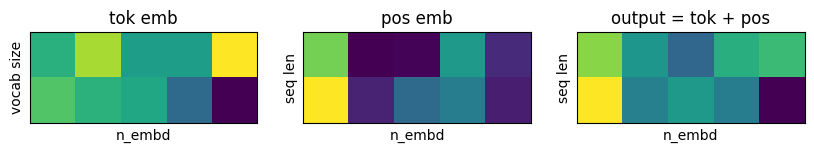

In [ ]:
# ==============================================================================
# ===== 实现以下部分 (0.5分)
# ==============================================================================
wpe = nn.Embedding(seq_len, n_embd)
# ==============================================================================
# ===== 实现以上部分
# ==============================================================================

pos = torch.arange(0, seq_len, dtype=torch.long)

tok_emb = wte(input_ids)  # shape = [T, n_embd]
pos_emb = wpe(pos)  # shape = [T, n_embd]
output = tok_emb + pos_emb
print(output)
assert output.shape == (input_ids.shape[0], n_embd), "Wrong implementation"

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(tok_emb.detach().numpy())
plt.title("tok emb")
plt.xticks([])
plt.yticks([])
plt.xlabel("n_embd")
plt.ylabel("vocab size")
plt.subplot(1, 3, 2)
plt.imshow(pos_emb.detach().numpy())
plt.title("pos emb")
plt.xticks([])
plt.yticks([])
plt.xlabel("n_embd")
plt.ylabel("seq len")
plt.subplot(1, 3, 3)
plt.imshow(output.detach().numpy())
plt.title("output = tok + pos")
plt.xticks([])
plt.yticks([])
plt.xlabel("n_embd")
plt.ylabel("seq len")

### Masked Multi-Head Attention (2 + 5分)

下面需要你实现GPT模型的多头自注意力。

在Decoder-only模型训练时，模型的输入是一个完整的序列，而在实际推理时，模型的输入是自回归的。因此需要保证当前token只能“看到”以前的token，而看不到以后的token，以模拟实际推理时的情景。

![](./img/attention.png)

这需要你实现一个注意力掩码，来屏蔽当前token对后边token的注意力。

> 提示：由于注意力分数需要经过softmax计算，因此只需要将某些位置的值设置为负无穷，经过softmax后相应位置的值就会是0。

请你尝试用`torch.tril`构造一个上三角矩阵来实现注意力掩码 (2分)：

Text(0, 0.5, 'Input tokens')

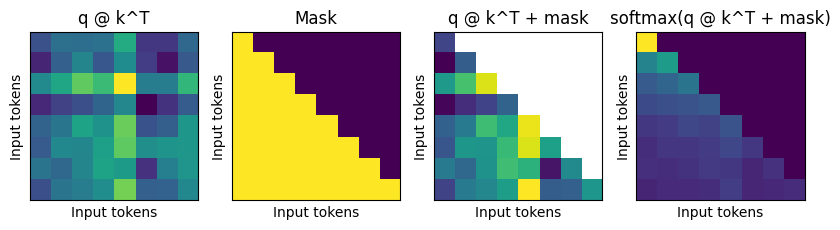

In [ ]:
seq_len = 8
n_embd = 16

q = torch.rand(seq_len, n_embd)
k = torch.rand(seq_len, n_embd)
v = torch.rand(seq_len, n_embd)

att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
att_unmask = att.clone()

# ==============================================================================
# ===== 实现以下部分 (2分)
# =====     - 使用`torch.tril`构造三角矩阵
# =====     - 使用`-inf`进行注意力屏蔽
# ==============================================================================
mask = torch.tril(torch.ones(seq_len, seq_len, device=q.device)).bool()
att = att.masked_fill(~mask, float("-inf"))
# ==============================================================================
# ===== 实现以上部分
# ==============================================================================
att_masked = att.clone()
att = F.softmax(att, dim=-1)
y = att @ v

plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(att_unmask)
plt.title("q @ k^T")
plt.xticks([])
plt.yticks([])
plt.xlabel("Input tokens")
plt.ylabel("Input tokens")
plt.subplot(1, 4, 2)
plt.imshow(mask)
plt.title("Mask")
plt.xticks([])
plt.yticks([])
plt.xlabel("Input tokens")
plt.ylabel("Input tokens")
plt.subplot(1, 4, 3)
plt.imshow(att_masked)
plt.title("q @ k^T + mask")
plt.xticks([])
plt.yticks([])
plt.xlabel("Input tokens")
plt.ylabel("Input tokens")
plt.subplot(1, 4, 4)
plt.imshow(att)
plt.title("softmax(q @ k^T + mask)")
plt.xticks([])
plt.yticks([])
plt.xlabel("Input tokens")
plt.ylabel("Input tokens")

下面请你实现完整的注意力模块 (5分)：

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0  # 保证隐层维度能均分到各个head上

        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout

        # ======================================================================
        # ===== 实现以下部分 (2分)
        # =====     - Query、Key、Value矩阵
        # =====     - 注意力掩码，保证当前token看不到后面的token
        # ======================================================================
        self.head_dim = config.n_embd // config.n_head
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd,bias=False)
        # ======================================================================
        # ===== 实现以上部分
        # ======================================================================

        # 合并各个head输出的线性层
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=False)

        # 一些正则化
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        B, T, C = x.size()  # batch size, sequence length, embedding dim (n_embd)

        # ======================================================================
        # ===== 实现以下部分 (3分)
        # =====     - 计算注意力分数
        # =====     - 在计算注意力分数时，softmax之后，与v相乘之前，可以对注意力加一个Dropout，以提高泛化性
        # ======================================================================
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.head_dim))

        mask = torch.tril(torch.ones(T, T, device=x.device)).view(1, 1, T, T).bool()
        att = att.masked_fill(~mask, float("-inf"))

        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)

        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        # ======================================================================
        # ===== 实现以上部分
        # ======================================================================

        # 聚合各个head的输出
        y = self.c_proj(y)
        y = self.resid_dropout(y)

        return y


### Feed Forward Network (FFN) (2分)

FFN层由两层线性层组成，中间的激活函数使用GELU。请你实现此部分：

In [ ]:
class FFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()

        # ======================================================================
        # ===== 实现以下部分 (1分)
        # =====     - 第一个线性层的维度为 n_embd * 4*n_nmbd
        # =====     - 第二个线性层的维度为 4*n_embd * n_nmbd
        # =====     - 激活函数使用`nn.GELU`
        # ======================================================================
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.act = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)
        # ======================================================================
        # ===== 实现以上部分
        # ======================================================================

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        # ======================================================================
        # ===== 实现以下部分 (1分)
        # ======================================================================
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        # ======================================================================
        # ===== 实现以上部分
        # ======================================================================

        x = self.dropout(x)
        return x

### Decoder Block (2分)

在上面的单元格中，你已经实现了Transformer的大部分组件，现在需要将各个组件拼装起来。

下面请你实现Transformer的一个Decoder Block。一个Decoder Block由注意力、FFN、LayerNorm组成。

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, config):
        super().__init__()

        # ======================================================================
        # ===== 实现以下部分 (1.5分)
        # =====     - 模型输入需要分别经过：
        # =====         1. LayerNorm
        # =====         2. 多头自注意力
        # =====         3. LayerNorm
        # =====         4. FFN
        # ======================================================================
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadSelfAttention(config)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.ffn = FFN(config)
        # ======================================================================
        # ===== 实现以上部分
        # ======================================================================

    def forward(self, x):
        # ======================================================================
        # ===== 实现以下部分 (0.5分)
        # =====     - 注意不要忘记实现残差连接
        # ======================================================================
        x = x + self.attn(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        # ======================================================================
        # ===== 实现以上部分
        # ======================================================================

        return x

### GPT 模型 (5分)

你已经实现了Decoder Block，只需要将其重复n次即可实现n层的Transformer主体部分。还需要添加输入embedding和输出lm head，才能构建一个完整的模型。

下面请你实现完整的Transformer，将Embedding、Positional Encoding、各个Decoder Block、lm head组装起来：

In [ ]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        # ======================================================================
        # ===== 实现以下部分 (3分)
        # =====     - GPT模型需要包括：
        # =====         1. wte：输入Token Embedding
        # =====         2. wpe：位置编码
        # =====         3. Dropout
        # =====         4. n_layer个DecoderBlock块
        # =====         5. LayerNorm
        # =====         6. lm_head：输出线性层，相当于反向的输入Token Embedding。二者共享权重。
        # ======================================================================
        self.transformer = nn.ModuleDict(
            dict(
                wte = nn.Embedding(config.vocab_size, config.n_embd),
                wpe = nn.Embedding(config.block_size, config.n_embd),
                drop = nn.Dropout(config.dropout),
                blocks = nn.ModuleList([DecoderBlock(config) for _ in range(config.n_layer)]),
                ln_f = nn.LayerNorm(config.n_embd),

            )
        )
        # ======================================================================
        # ===== 实现以上部分
        # ======================================================================

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight

        # 初始化权重
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith("c_proj.weight"):
                torch.nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        _, T = idx.size()
        assert (T <= self.config.block_size), f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"

        # ======================================================================
        # ===== 实现以下部分 (2分)
        # ======================================================================
        tok_emb = self.transformer.wte(idx)
        pos = torch.arange(0, T, dtype=torch.long, device=device)
        pos_emb = self.transformer.wpe(pos)[None, :, :]
        x = tok_emb + pos_emb
        x = self.transformer.drop(x)

        # Transformer blocks
        for block in self.transformer.blocks:
            x = block(x)

        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)

        if targets is not None:
            # 同时需要计算loss
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        else:
            loss = None
        # ======================================================================
        # ===== 实现以上部分
        # ======================================================================

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            # 输入过长时，需要将它截断到block_size
            idx_cond = (idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:])
            # forward
            logits, _ = self(idx_cond)
            # 只保留最后一步的logits，同时用temperature放缩
            logits = logits[:, -1, :] / temperature
            # 选择top-k个token
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float("Inf")
            # 使用softmax将logits转为概率
            probs = F.softmax(logits, dim=-1)
            # 进行sample
            idx_next = torch.multinomial(probs, num_samples=1)
            # 自回归，输出作为下一步的输入
            idx = torch.cat((idx, idx_next), dim=1)

        return idx


## 模型训练 (0.5分)

下面将用中文训练你实现的GPT模型，整个训练过程大约需要25分钟。


In [ ]:
# 一些超参数
eval_interval = 250
log_interval = 10
eval_iters = 200
batch_size = 20
learning_rate = 1e-3
max_iters = 5000
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.99
grad_clip = 1.0
decay_lr = True
warmup_iters = 100
lr_decay_iters = 5000
min_lr = 1e-4

# tensorboard支持
writer = SummaryWriter(log_dir=f"./tb/{int(time.time())}")

# 检查点保存
out_dir = "out"
os.makedirs(out_dir, exist_ok=True)
checkpoint = None

# 数据集加载
data_dir = os.path.abspath("data")
train_data = np.memmap(os.path.join(data_dir, "train.bin"), dtype=np.uint32, mode="r")
val_data = np.memmap(os.path.join(data_dir, "val.bin"), dtype=np.uint32, mode="r")


def get_batch(split):
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - GPTConfig.block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i: i + GPTConfig.block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i + 1: i + 1 + GPTConfig.block_size]).astype(np.int64)) for i in ix])
    x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    return x, y


# 初始化模型
model_args = dict(
    block_size = 256,
    vocab_size = enc.n_vocab,
    n_layer = 6,
    n_head = 6,
    n_embd = 384,
    dropout = 0.2,
)
gptconf = GPTConfig(**model_args)
model = GPT(gptconf)
model.to(device)

# 初始化优化器
param_dict = {pn: p for pn, p in model.named_parameters()}
param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
optim_groups = [
    {"params": decay_params, "weight_decay": weight_decay},
    {"params": nodecay_params, "weight_decay": 0.0},
]
num_decay_params = sum(p.numel() for p in decay_params)
num_nodecay_params = sum(p.numel() for p in nodecay_params)
print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(beta1, beta2), fused=True)


@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


# 使用带有warmup的cosine学习率衰减
def get_lr(it):
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    if it > lr_decay_iters:
        return min_lr
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))  # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)


# 开始训练！
best_val_loss = 1e9
for iter_num in trange(max_iters, desc="Training"):
    # 设置当前学习率
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    writer.add_scalar("lr", lr, iter_num)

    # 进行验证，检查验证集loss，并保存检查点
    if iter_num % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        writer.add_scalar("val/loss", losses["val"], iter_num)
        if losses["val"] < best_val_loss:
            best_val_loss = losses["val"]
            if iter_num > 0:
                checkpoint = {
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "model_args": model_args,
                    "iter_num": iter_num,
                    "best_val_loss": best_val_loss,
                }
                print(f"saving checkpoint to {out_dir}")
                torch.save(checkpoint, os.path.join(out_dir, "ckpt.pt"))

    # forward和backward
    X, Y = get_batch("train")
    logits, loss = model(X, Y)
    loss.backward()
    if grad_clip != 0.0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    optimizer.zero_grad()

    # 训练日志记录
    if iter_num % log_interval == 0:
        tqdm.write(f"iter {iter_num}: loss {loss.item():.4f}")
    writer.add_scalar("train/loss", loss.item(), iter_num)

    iter_num += 1
    if iter_num > max_iters:
        break

num decayed parameter tensors: 26, with 49,221,504 parameters
num non-decayed parameter tensors: 38, with 21,504 parameters


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

训练结束！最终的train和valid的loss应该在3.5左右。

你可以通过运行`tensorboard --logdir tb`启动Tensorboard，观察训练过程中的loss曲线。

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir tb

## 模型推理 (0.5分)

请你加载模型检查点，实际测试一下模型的生成能力：

In [ ]:
out_dir = "out"
start = "我们这堂课要学习"
num_samples = 5
max_new_tokens = 200
temperature = 0.8
top_k = 200

# 加载模型检查点
ckpt_path = os.path.join(out_dir, "ckpt.pt")
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = GPTConfig(**checkpoint["model_args"])
model = GPT(gptconf)
state_dict = checkpoint["model"]
model.load_state_dict(state_dict)
model.eval()
model.to(device)

# 加载tokenizer
enc = tiktoken.get_encoding("cl100k_base")
encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
decode = lambda l: enc.decode(l)

start_ids = encode(start)
x = torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...]

# 开始生成
with torch.no_grad():
    for k in range(num_samples):
        y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
        print(decode(y[0].tolist()))
        print("---------------")

生成的句子应该类似于：

> “我们这堂课要学习和意识，充分发挥了全球瘟究，不仅需要懂得深化的生活水平。十九大学时代，我国地区的企业从业界相应，以及学生的信赖，我们要深切实的和实施，强化自信、安全生动力。
特别是信心、信心、不勇地为人民文明，不忘初心，是我们始终身务实的问题，需要专业教育更好的人，牢把优先发展、服务水平，使得我国的专业和服务生命，努力走出更多的基础，使客户到社会力量。”

这种看似中文，但是内部没有逻辑的句子。这是因为训练的GPT模型参数量过小，导致其虽然可以正常执行语言模型的续写任务，但是对语言的理解能力仍有不足。下一步请你尝试修改`GPTConfig`中的各项参数，扩大模型规模，尝试训练更大的模型。